In [1]:
from pyNBA.Data.sql import SQL
sql = SQL()
sql.create_connection()
sql.create_tables()

/Users/brandonshimiaie/Projects/pyNBA/sqlite/db/nba.db
2.6.0


In [6]:
# for data
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from datetime import datetime, timedelta
from pyNBA.Data.data import QueryData
from pyNBA.Models.helpers import CleanData
import math

# for features
from pyNBA.Models.features import FeatureCreation
from pyNBA.Models.cluster import Cluster, Evaluate
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from research import Helpers
from statsmodels.graphics.api import abline_plot

# for statistical tests
from scipy.stats import shapiro
import pingouin as pg

# for machine learning
from sklearn import model_selection, preprocessing, ensemble, neighbors, linear_model, svm, neural_network, metrics
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# for explainer
from lime import lime_tabular

# misc
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [7]:
query_data = QueryData(update=True)
boxscores = query_data.query_boxscore_data()

/Users/brandonshimiaie/Projects/pyNBA/sqlite/db/nba.db
2.6.0


In [9]:
temp = boxscores.loc[boxscores['SEASONTYPE'] == 'Regular Season']

In [10]:
team_boxscores = temp.groupby(['SEASON', 'DATE', 'TEAM', 'OPP_TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_POSSESSIONS': x['POSS'].sum(),
        'TEAM_OREB': x['OREB'].sum(),
        'TEAM_TOV': x['TOV'].sum(),
        'TEAM_ATTEMPTS': x['TOTAL_ATTEMPTS'].sum(),
        'TEAM_TFOUL_PTS': x['TFOUL_PTS'].sum()
    })
).reset_index()

In [11]:
team_boxscores['IMPLIED_ATTEMPTS'] = team_boxscores['TEAM_POSSESSIONS']/5 + team_boxscores['TEAM_OREB'] - team_boxscores['TEAM_TOV']
team_boxscores['ATTEMPT_DIFF'] = team_boxscores['IMPLIED_ATTEMPTS'] - team_boxscores['TEAM_ATTEMPTS']
print(team_boxscores['ATTEMPT_DIFF'].mean())
display(team_boxscores.loc[team_boxscores['ATTEMPT_DIFF'] == team_boxscores['ATTEMPT_DIFF'].max()])

-0.014038008045498696


,SEASON,DATE,TEAM,OPP_TEAM,TEAM_POSSESSIONS,TEAM_OREB,TEAM_TOV,TEAM_ATTEMPTS,TEAM_TFOUL_PTS,IMPLIED_ATTEMPTS,ATTEMPT_DIFF
8509,2017-18,2018-01-03,WAS,NYK,518,6,12,90,2,97.6,7.6
13545,2019-20,2020-01-17,PHI,CHI,483,9,11,87,1,94.6,7.6


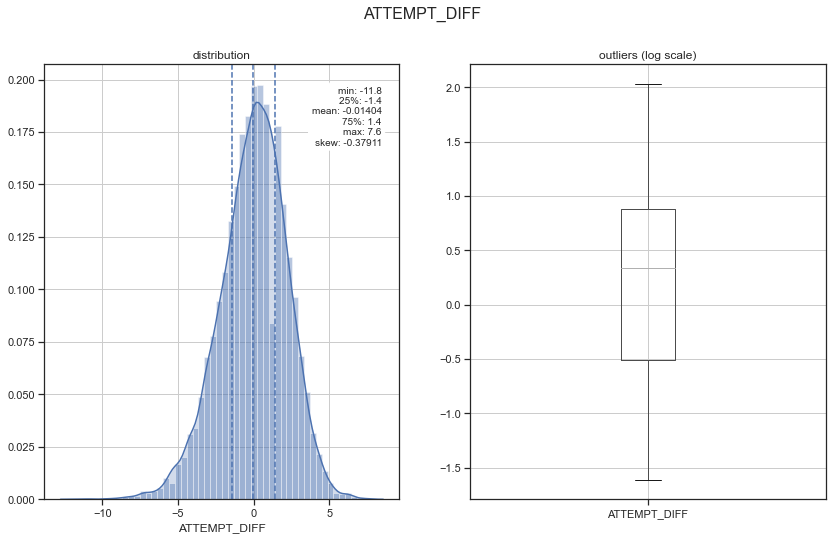

In [12]:
helpers = Helpers()
helpers.visualize_variable_distribution(team_boxscores, 'ATTEMPT_DIFF', figsize=(14, 8))

In [13]:
print(team_boxscores['TEAM_TFOUL_PTS'].mean())

0.6177000971008462


In [57]:
import time
import requests
from bs4 import BeautifulSoup
from pyNBA.Data.constants import LINEUP_TEAM_TO_NBA_TEAM, LINEUP_NAME_TO_NBA_NAME

import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [58]:
from nba_api.stats.static.teams import find_team_by_abbreviation
from nba_api.stats.endpoints import CommonTeamRoster

In [59]:
def prepare_team(team):
    if team in LINEUP_TEAM_TO_NBA_TEAM:
        return LINEUP_TEAM_TO_NBA_TEAM[team]
    return team

def prepare_name(name, team):
    if name in LINEUP_NAME_TO_NBA_NAME:
        if isinstance(LINEUP_NAME_TO_NBA_NAME[name], dict):
            return LINEUP_NAME_TO_NBA_NAME[name][team]
        return LINEUP_NAME_TO_NBA_NAME[name]
    return name

In [60]:
import pandas as pd
current_player_data = pd.DataFrame(columns=[
    'TEAM', 'NAME', 'START', 'PLAYERSTATUS', 'PLAYERCHANCE'
])

In [61]:
def get_player_data(lineup):
    player_data = pd.DataFrame(columns=[
        'NAME', 'START', 'PLAYERSTATUS'
    ])

    players_added = {}
    lineup_status = ''
    start = 1

    rows = lineup.find_all('li')
    for row in rows:
        row_class = row['class']
        if row_class[0] == 'lineup__status':
            lineup_status_data = row_class[1]
            if lineup_status_data == 'is-expected':
                lineup_status = 'Expected'
            elif lineup_status_data == 'is-confirmed':
                lineup_status = 'Confirmed'
        elif row_class[0] == 'lineup__title':
            start = 0
        elif row_class[0] == 'lineup__player':
            player_start = start
            player_position = row.find('div', class_='lineup__pos').text
            player_name = row.find('a').text
            status_data = row.find('span', class_='lineup__inj')
            player_status = 'Healthy' if status_data is None else status_data.text
            player_chance = int(row_class[1].split('-')[-1])
            if player_position != 'BE' and player_name not in players_added:
                temp = pd.Series(
                    [player_name, start, player_status, player_chance],
                    index=['NAME', 'START', 'PLAYERSTATUS', 'PLAYERCHANCE']
                    )
                player_data = player_data.append(temp, ignore_index=True)
                players_added[player_name] = 1
                
    return player_data, lineup_status
    

In [62]:
team_to_opp_team = {}
team_to_status = {}

In [63]:
URL = 'https://www.rotowire.com/basketball/nba-lineups.php'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')

games = soup.find_all('div', class_='lineup is-nba')
for game in games:
    away_team = game.find('a', class_='lineup__team is-visit').find('div', class_='lineup__abbr').text
    away_team = prepare_team(away_team)
    away_lineup = game.find('ul', class_='lineup__list is-visit')
    away_player_data, away_lineup_status = get_player_data(away_lineup)
    away_player_data['TEAM'] = away_team
    away_player_data['NAME'] = away_player_data['NAME'].apply(lambda x: prepare_name(x, away_team))

    home_team = game.find('a', class_='lineup__team is-home').find('div', class_='lineup__abbr').text
    home_team = prepare_team(home_team)
    home_lineup = game.find('ul', class_='lineup__list is-home')
    home_player_data, home_lineup_status = get_player_data(home_lineup)
    home_player_data['TEAM'] = home_team
    home_player_data['NAME'] = home_player_data['NAME'].apply(lambda x: prepare_name(x, home_team))
    
    team_to_opp_team[away_team] = home_team
    team_to_opp_team[home_team] = away_team
    team_to_status[away_team] = away_lineup_status
    team_to_status[home_team] = home_lineup_status
    
    current_player_data = current_player_data.append(away_player_data)
    current_player_data = current_player_data.append(home_player_data)

In [64]:
roster_data = pd.DataFrame()
for team_abbreviation in current_player_data['TEAM'].unique():
    print(team_abbreviation)
    team = find_team_by_abbreviation(team_abbreviation)
    team_id = team['id']

    roster = CommonTeamRoster(season='2020-21', team_id=team_id).get_data_frames()[0]
    time.sleep(0.500)
    
    roster['TEAM'] = team['abbreviation']

    roster_data = roster_data.append(roster)

roster_data = roster_data.rename(columns={'TeamID': 'TEAMID', 'PLAYER_ID': 'PLAYERID', 'PLAYER': 'NAME'})

roster_data['POSITION'] = roster_data['POSITION'].str.replace('G', 'Guard')
roster_data['POSITION'] = roster_data['POSITION'].str.replace('F', 'Forward')
roster_data['POSITION'] = roster_data['POSITION'].str.replace('C', 'Center')

CHA
ORL
DET
WAS
ATL
MEM


In [65]:
current_data = roster_data.merge(current_player_data, on=['NAME', 'TEAM'], how='left')

current_data['LINEUPSTATUS'] = current_data['TEAM'].apply(lambda x: team_to_status[x])
current_data['OPP_TEAM'] = current_data['TEAM'].apply(lambda x: team_to_opp_team[x])

from datetime import datetime
current_date = datetime.now().strftime("%Y-%m-%d")
current_data['DATE'] = current_date

current_data['START'] = current_data['START'].fillna(0)
current_data['PLAYERSTATUS'] = current_data['PLAYERSTATUS'].fillna('Healthy')
current_data['PLAYERCHANCE'] = current_data['PLAYERCHANCE'].fillna(100)

In [66]:
current_data = current_data[['LINEUPSTATUS', 'PLAYERID', 'SEASON', 'DATE', 'TEAM', 'OPP_TEAM', 'NAME', 'POSITION', 'START', 'PLAYERSTATUS', 'PLAYERCHANCE']]
display(current_data)

,LINEUPSTATUS,PLAYERID,SEASON,DATE,TEAM,OPP_TEAM,NAME,POSITION,START,PLAYERSTATUS,PLAYERCHANCE
0,Expected,1630270,2020,2020-12-19,CHA,ORL,Xavier Sneed,Forward,0,Healthy,100.0
1,Expected,1630176,2020,2020-12-19,CHA,ORL,Vernon Carey Jr.,Forward-Center,0,Healthy,100.0
2,Expected,1630203,2020,2020-12-19,CHA,ORL,Grant Riller,Guard,0,OUT,0.0
3,Expected,1630268,2020,2020-12-19,CHA,ORL,Nate Darling,,0,Healthy,100.0
4,Expected,1628970,2020,2020-12-19,CHA,ORL,Miles Bridges,Forward,1,Healthy,100.0
...,...,...,...,...,...,...,...,...,...,...,...
107,Expected,1629634,2020,2020-12-19,MEM,ATL,Brandon Clarke,Forward-Guard,1,Healthy,100.0
108,Expected,202685,2020,2020-12-19,MEM,ATL,Jonas Valanciunas,Center,1,Healthy,100.0
109,Expected,1626145,2020,2020-12-19,MEM,ATL,Tyus Jones,Guard,0,Healthy,100.0
110,Expected,1628415,2020,2020-12-19,MEM,ATL,Dillon Brooks,Guard-Forward,1,Healthy,50.0


In [67]:
print(len(current_data.loc[current_data['START'] == 1]))
print(len(current_data['TEAM'].unique()))

30
6


In [68]:
print(current_player_data.loc[~current_player_data['NAME'].isin(roster_data['NAME'].unique())]['NAME'].unique())

[]


In [21]:
print(roster_data.loc[roster_data['NAME'].str.contains('Green')])

        TEAMID SEASON LeagueID            NAME     PLAYER_SLUG NUM  \
8   1610612755   2020       00     Danny Green     danny-green  14   
8   1610612751   2020       00      Jeff Green      jeff-green   8   
13  1610612738   2020       00   Javonte Green   javonte-green  43   
7   1610612743   2020       00  JaMychal Green  jamychal-green   4   

          POSITION HEIGHT WEIGHT    BIRTH_DATE   AGE EXP          SCHOOL  \
8            Guard    6-6    215  JUN 22, 1987  33.0  11  North Carolina   
8          Forward    6-8    235  AUG 28, 1986  34.0  12      Georgetown   
13   Guard-Forward    6-4    205  JUL 23, 1993  27.0   1         Radford   
7   Forward-Center    6-8    227  JUN 21, 1990  30.0   6         Alabama   

    PLAYERID TEAM  
8     201980  PHI  
8     201145  BKN  
13   1629750  BOS  
7     203210  DEN  


In [69]:
query_data = QueryData(update=False)
boxscores = query_data.query_boxscore_data()
boxscores = boxscores.loc[boxscores['SEASON'] == '2020-21']

/Users/brandonshimiaie/Projects/pyNBA/sqlite/db/nba.db
2.6.0


In [70]:
team_boxscores = boxscores.groupby(['SEASON', 'DATE', 'TEAM', 'OPP_TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_POSSESSIONS': x['POSS'].sum()/5,
        'TEAM_OREB': x['OREB'].sum(),
        'TEAM_DREB': x['DREB'].sum()
    })
).reset_index()

opp_team_boxscores = team_boxscores.drop(columns='OPP_TEAM')
opp_team_boxscores = opp_team_boxscores.rename(columns={
    'TEAM': 'OPP_TEAM', 'TEAM_POSSESSIONS': 'OPP_TEAM_POSSESSIONS', 'TEAM_OREB': 'OPP_TEAM_OREB', 'TEAM_DREB': 'OPP_TEAM_DREB'
    })
team_boxscores = team_boxscores.merge(opp_team_boxscores, on=['SEASON', 'DATE', 'OPP_TEAM'], how='left')

team_boxscores['TEAM_OREB_CHANCES'] = team_boxscores['TEAM_OREB'] + team_boxscores['OPP_TEAM_DREB']
team_boxscores['TEAM_DREB_CHANCES'] = team_boxscores['TEAM_DREB'] + team_boxscores['OPP_TEAM_OREB']

# average team oreb chances/possession
team_boxscores['TEAM_OREB_CHANCES/POSSESSION'] = team_boxscores['TEAM_OREB_CHANCES']/team_boxscores['TEAM_POSSESSIONS']

team_boxscores = feature_creation.expanding_weighted_mean(
    df=team_boxscores, group_col_names=['SEASON', 'TEAM'], col_name='TEAM_OREB_CHANCES/POSSESSION',
    new_col_name='AVG_TEAM_OREB_CHANCES/POSSESSION', weight_col_name='TEAM_POSSESSIONS'
)

# average oreb chances/possession that opp team allowed
team_boxscores = feature_creation.expanding_weighted_mean(
    df=team_boxscores, group_col_names=['SEASON', 'OPP_TEAM'], col_name='TEAM_OREB_CHANCES/POSSESSION',
    new_col_name='AVG_OREB_CHANCES/POSSESSION_OPP_TEAM_ALLOWED', weight_col_name='TEAM_POSSESSIONS'
)

# average oreb chances/possession allowed that team played against
season_stats = team_boxscores.groupby(['SEASON', 'TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_OREB_ALLOWED(SEASON)': x['OPP_TEAM_OREB'].mean(),
        'TEAM_OREB_CHANCES(SEASON)': x['TEAM_OREB_CHANCES'].mean(),
        'TEAM_OREB_CHANCES_ALLOWED(SEASON)': x['TEAM_DREB_CHANCES'].mean(),
        'TEAM_DREB_ALLOWED(SEASON)': x['OPP_TEAM_DREB'].mean(),
        'TEAM_DREB_CHANCES(SEASON)': x['TEAM_DREB_CHANCES'].mean(),
        'TEAM_DREB_CHANCES_ALLOWED(SEASON)': x['TEAM_DREB_CHANCES'].mean(),
        'TEAM_POSSESSIONS(SEASON)': x['TEAM_POSSESSIONS'].mean(),
        'TEAM_POSSESSIONS_ALLOWED(SEASON)': x['OPP_TEAM_POSSESSIONS'].mean()
    })
).reset_index()

opp_season_stats = season_stats.rename(columns={
    'TEAM': 'OPP_TEAM',
    'TEAM_OREB_ALLOWED(SEASON)': 'OPP_TEAM_OREB_ALLOWED(SEASON)',
    'TEAM_OREB_CHANCES(SEASON)': 'OPP_TEAM_OREB_CHANCES(SEASON)',
    'TEAM_OREB_CHANCES_ALLOWED(SEASON)': 'OPP_TEAM_OREB_CHANCES_ALLOWED(SEASON)',
    'TEAM_DREB_ALLOWED(SEASON)': 'OPP_TEAM_DREB_ALLOWED(SEASON)',
    'TEAM_DREB_CHANCES(SEASON)': 'OPP_TEAM_DREB_CHANCES(SEASON)',
    'TEAM_DREB_CHANCES_ALLOWED(SEASON)': 'OPP_TEAM_DREB_CHANCES_ALLOWED(SEASON)',
    'TEAM_POSSESSIONS(SEASON)': 'OPP_TEAM_POSSESSIONS(SEASON)',
    'TEAM_POSSESSIONS_ALLOWED(SEASON)': 'OPP_TEAM_POSSESSIONS_ALLOWED(SEASON)'
    })


team_boxscores = team_boxscores.merge(season_stats, on=['SEASON', 'TEAM'], how='left')
team_boxscores = team_boxscores.merge(opp_season_stats, on=['SEASON', 'OPP_TEAM'], how='left')

team_boxscores['OPP_TEAM_OREB_CHANCES/POSSESSION_ALLOWED(SEASON)'] = \
    team_boxscores['OPP_TEAM_OREB_CHANCES_ALLOWED(SEASON)']/team_boxscores['OPP_TEAM_POSSESSIONS_ALLOWED(SEASON)']

team_boxscores = feature_creation.expanding_weighted_mean(
    df=team_boxscores, group_col_names=['SEASON', 'TEAM'], col_name='OPP_TEAM_OREB_CHANCES/POSSESSION_ALLOWED(SEASON)',
    new_col_name='AVG_OREB_CHANCES/POSSESSION_ALLOWED(SEASON)_TEAM_P.A.', weight_col_name='TEAM_POSSESSIONS'
)

# average oreb chances/possession that opp team played against
team_boxscores['TEAM_OREB_CHANCES/POSSESSION(SEASON)'] = \
    team_boxscores['TEAM_OREB_CHANCES(SEASON)']/team_boxscores['TEAM_POSSESSIONS(SEASON)']

team_boxscores = feature_creation.expanding_weighted_mean(
    df=team_boxscores, group_col_names=['SEASON', 'OPP_TEAM'], col_name='TEAM_OREB_CHANCES/POSSESSION(SEASON)',
    new_col_name='AVG_OREB_CHANCES/POSSESSION(SEASON)_OPP_TEAM_P.A.', weight_col_name='OPP_TEAM_POSSESSIONS'
)

# team oreb chances/possession
team_boxscores['TEAM_OREB_CHANCES/POSSESSION_HAT'] = \
    2*team_boxscores['AVG_TEAM_OREB_CHANCES/POSSESSION'] - \
        team_boxscores['AVG_OREB_CHANCES/POSSESSION_ALLOWED(SEASON)_TEAM_P.A.']

# opp team oreb chances/possession allowed
team_boxscores['OPP_TEAM_OREB_CHANCES/POSSESSION_ALLOWED_HAT'] = \
    2*team_boxscores['AVG_OREB_CHANCES/POSSESSION_OPP_TEAM_ALLOWED'] - \
        team_boxscores['AVG_OREB_CHANCES/POSSESSION(SEASON)_OPP_TEAM_P.A.']

boxscores = boxscores.merge(team_boxscores, on=['SEASON', 'DATE', 'TEAM', 'OPP_TEAM'], how='left')

boxscores['OREB_CHANCES'] = np.nan
boxscores.loc[boxscores['OREB'] > 0, 'OREB_CHANCES'] = (
    boxscores.loc[boxscores['OREB'] > 0, 'OREB'] / boxscores.loc[boxscores['OREB'] > 0, 'OREB_PCT']
    ).apply(lambda x: round(x))
boxscores.loc[boxscores['OREB'] == 0, 'OREB_CHANCES'] = \
    boxscores.loc[boxscores['OREB'] == 0, 'TEAM_OREB_CHANCES/POSSESSION']*boxscores.loc[boxscores['OREB'] == 0, 'POSS']

boxscores['TEAM_DREB_CHANCES/POSSESSION'] = boxscores['TEAM_DREB_CHANCES']/boxscores['TEAM_POSSESSIONS']

boxscores['DREB_CHANCES'] = np.nan
boxscores.loc[boxscores['DREB'] > 0, 'DREB_CHANCES'] = (
    boxscores.loc[boxscores['DREB'] > 0, 'DREB'] / boxscores.loc[boxscores['DREB'] > 0, 'DREB_PCT']
    ).apply(lambda x: round(x))
boxscores.loc[boxscores['DREB'] == 0, 'DREB_CHANCES'] = \
    boxscores.loc[boxscores['DREB'] == 0, 'TEAM_DREB_CHANCES/POSSESSION']*boxscores.loc[boxscores['DREB'] == 0, 'POSS']

temp = boxscores.groupby(['SEASON', 'DATE', 'TEAM', 'OPP_TEAM']).apply(
    lambda x: pd.Series({
        'IMPLIED_TEAM_OREB_CHANCES': x['OREB_CHANCES'].sum()/5,
        'IMPLIED_TEAM_DREB_CHANCES': x['DREB_CHANCES'].sum()/5
    })
).reset_index()
boxscores = boxscores.merge(temp, on=['SEASON', 'DATE', 'TEAM', 'OPP_TEAM'], how='left')

# average player oreb/chance
boxscores['OREB_CHANCES'] = boxscores['OREB_CHANCES']*(boxscores['TEAM_OREB_CHANCES']/boxscores['IMPLIED_TEAM_OREB_CHANCES']) 
boxscores['OREB/OREB_CHANCE'] = boxscores['OREB']/boxscores['OREB_CHANCES']

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='OREB/OREB_CHANCE',
    new_col_name='AVG_OREB/OREB_CHANCE', weight_col_name='OREB_CHANCES'
)

# average player dreb/chance
boxscores['DREB_CHANCES'] = boxscores['DREB_CHANCES']*(boxscores['TEAM_DREB_CHANCES']/boxscores['IMPLIED_TEAM_DREB_CHANCES']) 
boxscores['DREB/DREB_CHANCE'] = boxscores['DREB']/boxscores['DREB_CHANCES']

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='DREB/DREB_CHANCE',
    new_col_name='AVG_DREB/DREB_CHANCE', weight_col_name='DREB_CHANCES'
)

# average oreb/oreb chance that opp team allowed
team_game_boxscores = boxscores.groupby(['SEASON', 'DATE', 'TEAM', 'OPP_TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_OREB': x['OREB'].sum(),
        'TEAM_OREB_CHANCES': x['OREB_CHANCES'].sum()/5,
        'TEAM_DREB': x['DREB'].sum(),
        'TEAM_DREB_CHANCES': x['DREB_CHANCES'].sum()/5
    })
).reset_index()

opp_team_game_boxscores = team_game_boxscores.drop(columns='OPP_TEAM')
opp_team_game_boxscores = opp_team_game_boxscores.rename(columns={
    'TEAM': 'OPP_TEAM', 'TEAM_OREB': 'OPP_TEAM_OREB',
    'TEAM_OREB_CHANCES': 'OPP_TEAM_OREB_CHANCES', 'TEAM_DREB': 'OPP_TEAM_DREB',
    'TEAM_DREB_CHANCES': 'OPP_TEAM_DREB_CHANCES'
    })
team_game_boxscores = team_game_boxscores.merge(
    opp_team_game_boxscores, on=['SEASON', 'DATE', 'OPP_TEAM'], how='left'
    )

team_game_boxscores['TEAM_OREB/OREB_CHANCE'] = \
    team_game_boxscores['TEAM_OREB']/team_game_boxscores['TEAM_OREB_CHANCES']

team_game_boxscores = feature_creation.expanding_weighted_mean(
    df=team_game_boxscores, group_col_names=['SEASON', 'OPP_TEAM'],
    col_name='TEAM_OREB/OREB_CHANCE', new_col_name='AVG_TEAM_OREB/OREB_CHANCE_OPP_ALLOWED',
    weight_col_name='TEAM_OREB_CHANCES'
)

# average dreb/dreb chance that opp team allowed
team_game_boxscores['TEAM_DREB/DREB_CHANCE'] = \
    team_game_boxscores['TEAM_DREB']/team_game_boxscores['TEAM_DREB_CHANCES']

team_game_boxscores = feature_creation.expanding_weighted_mean(
    df=team_game_boxscores, group_col_names=['SEASON', 'OPP_TEAM'],
    col_name='TEAM_DREB/DREB_CHANCE', new_col_name='AVG_TEAM_DREB/DREB_CHANCE_OPP_ALLOWED',
    weight_col_name='TEAM_DREB_CHANCES'
)

boxscores = boxscores.merge(
    team_game_boxscores, on=['SEASON', 'DATE', 'TEAM', 'OPP_TEAM'], how='left'
)

# average oreb/oreb chance allowed that player played against
boxscores['OPP_TEAM_OREB/OREB_CHANCE_ALLOWED(SEASON)'] = \
    boxscores['OPP_TEAM_OREB_ALLOWED(SEASON)'] / boxscores['OPP_TEAM_OREB_CHANCES_ALLOWED(SEASON)']

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'],
    col_name='OPP_TEAM_OREB/OREB_CHANCE_ALLOWED(SEASON)',
    new_col_name='AVG_TEAM_OREB/OREB_CHANCE(SEASON)_ALLOWED_PLAYER_P.A',
    weight_col_name='OREB_CHANCES'
)

# average dreb/dreb chance allowed that player played against
boxscores['OPP_TEAM_DREB/DREB_CHANCE_ALLOWED(SEASON)'] = \
    boxscores['OPP_TEAM_DREB_ALLOWED(SEASON)'] / boxscores['OPP_TEAM_DREB_CHANCES_ALLOWED(SEASON)']

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'],
    col_name='OPP_TEAM_DREB/DREB_CHANCE_ALLOWED(SEASON)',
    new_col_name='AVG_TEAM_DREB/DREB_CHANCE(SEASON)_ALLOWED_PLAYER_P.A',
    weight_col_name='DREB_CHANCES'
)

# oreb/oreb chance defense
boxscores['OREB/CH_DEF'] = \
    boxscores['AVG_TEAM_OREB/OREB_CHANCE_OPP_ALLOWED'] / \
        boxscores['AVG_TEAM_OREB/OREB_CHANCE(SEASON)_ALLOWED_PLAYER_P.A']

# dreb/dreb chance defense
boxscores['DREB/CH_DEF'] = \
    boxscores['AVG_TEAM_DREB/DREB_CHANCE_OPP_ALLOWED'] / \
        boxscores['AVG_TEAM_DREB/DREB_CHANCE(SEASON)_ALLOWED_PLAYER_P.A']

In [72]:
display(boxscores[['TEAM_OREB/OREB_CHANCE', 'AVG_TEAM_OREB/OREB_CHANCE_OPP_ALLOWED', 'AVG_TEAM_OREB/OREB_CHANCE(SEASON)_ALLOWED_PLAYER_P.A']])

,TEAM_OREB/OREB_CHANCE,AVG_TEAM_OREB/OREB_CHANCE_OPP_ALLOWED,AVG_TEAM_OREB/OREB_CHANCE(SEASON)_ALLOWED_PLAYER_P.A
0,0.065517,NaN,NaN
1,0.065517,NaN,NaN
2,0.038462,NaN,NaN
3,0.038462,NaN,NaN
4,0.038462,NaN,NaN
...,...,...,...
1694,0.015000,0.036923,0.177489
1695,0.046154,0.040559,0.134328
1696,0.015000,0.036923,0.179484
1697,0.046154,0.040559,0.164333


In [50]:
boxscores = boxscores.merge(q_boxscores, on=['GAMEID', 'PLAYERID'], how='left')
boxscores[q_boxscores.columns] = boxscores[q_boxscores.columns].fillna(0)
boxscores['SP(REG)'] = boxscores['SP(Q1)'] + boxscores['SP(Q2)'] + boxscores['SP(Q3)'] + boxscores['SP(Q4)']
boxscores['MP(REG)'] = boxscores['SP(REG)']/60
boxscores['MP(Q4)'] = boxscores['SP(Q4)']/60

In [52]:
boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID', 'START'], col_name='MP(REG)',
    new_col_name='AVG_MP(REG)_R'
)

In [54]:
boxscores[['MP(Q4)', 'AVG_MP(REG)_R']] = boxscores[['MP(Q4)', 'AVG_MP(REG)_R']].fillna(0)
display(boxscores)

,GAMEID,PLAYERID,TEAM,OPP_TEAM,DATE,COMMENT,START,SECONDSPLAYED,PTS,FGM,FGA,FG3M,FG3A,FTM,FTA,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,PCT_AST_2PM,PCT_AST_3PM,OREB,OREB_PCT,DREB,DREB_PCT,AST,AST_PCT,AST_RATIO,STL,BLK,TOV,PF,PLUSMINUS,USG_PCT,PACE,POSS,TOTAL_ATTEMPTS,TOTAL_PTS,TOTAL_FTA,TOTAL_FTM,SHOT_ATTEMPTS,SHOT_PTS,SHOT_FTA,SHOT_FTM,SFOUL_ATTEMPTS,SFOUL_PTS,SFOUL_FTA,SFOUL_FTM,PFOUL_ATTEMPTS,PFOUL_PTS,PFOUL_FTA,PFOUL_FTM,TFOUL_ATTEMPTS,TFOUL_PTS,TFOUL_FTA,TFOUL_FTM,ID,SEASON,SEASONTYPE,HTM,VTM,W,SP(Q1),SP(Q2),SP(Q3),SP(Q4),SP(Q5),SP(Q6),SP(Q7),SP(Q8),SP(REG),MP(REG),MP(Q4),AVG_MP(REG)_R
0,0012000001,200765,ATL,ORL,2020-12-11,DND - Injury/Illness,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.0,0,0.000,0.0,0.000,0,0.000,0.0,0,0,0,0,0,0.000,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0012000001,2020-21,Pre Season,ATL,ORL,ORL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,0012000001,201568,ATL,ORL,2020-12-11,,0,1216,14,3,7,1,5,7,8,3,2,0,2,0.500,1.0,0,0.000,4.0,0.182,0,0.000,0.0,1,1,0,2,14,0.169,111.32,48,10,14,8,7,7,7,1,0,2,5,5,5,1,2,2,2,0,0,0,0,0012000001,2020-21,Pre Season,ATL,ORL,ORL,360.0,308.0,391.0,156.0,0.0,0.0,0.0,0.0,1215.0,20.250000,2.600000,0.000000
2,0012000001,202329,ORL,ATL,2020-12-11,DND - Injury/Illness,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.0,0,0.000,0.0,0.000,0,0.000,0.0,0,0,0,0,0,0.000,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0012000001,2020-21,Pre Season,ATL,ORL,ORL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,0012000001,202696,ORL,ATL,2020-12-11,,1,1520,18,8,14,2,7,0,1,5,0,5,4,0.833,1.0,1,0.045,10.0,0.270,4,0.200,21.1,1,1,1,2,25,0.254,105.16,55,14,18,1,0,14,18,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0012000001,2020-21,Pre Season,ATL,ORL,ORL,538.0,388.0,594.0,0.0,0.0,0.0,0.0,0.0,1520.0,25.333333,0.000000,0.000000
4,0012000001,203082,ORL,ATL,2020-12-11,DND - Injury/Illness,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.0,0,0.000,0.0,0.000,0,0.000,0.0,0,0,0,0,0,0.000,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0012000001,2020-21,Pre Season,ATL,ORL,ORL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1694,0012000046,1629659,LAL,PHX,2020-12-18,,0,1410,12,5,8,2,2,0,0,5,0,0,2,0.667,1.0,0,0.000,2.0,0.083,2,0.133,16.7,1,0,2,3,4,0.182,102.13,50,8,12,0,0,8,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0012000046,2020-21,Pre Season,PHX,LAL,LAL,124.0,379.0,187.0,720.0,0.0,0.0,0.0,0.0,1410.0,23.500000,12.000000,24.416667
1695,0012000046,1629661,PHX,LAL,2020-12-18,,0,944,8,3,8,2,6,0,0,0,0,0,2,0.000,0.5,1,0.053,1.0,0.053,1,0.125,9.1,1,0,2,2,-8,0.238,108.31,35,8,8,0,0,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0012000046,2020-21,Pre Season,PHX,LAL,LAL,259.0,183.0,299.0,203.0,0.0,0.0,0.0,0.0,944.0,15.733333,3.383333,0.000000
1696,0012000046,1629719,LAL,PHX,2020-12-18,,0,214,4,2,3,0,0,0,0,0,0,2,4,1.000,0.0,1,0.333,0.0,0.000,0,0.000,0.0,0,0,0,1,-2,0.375,94.21,7,3,4,0,0,3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0012000046,2020-21,Pre Season,PHX,LAL,LAL,0.0,0.0,0.0,214.0,0.0,0.0,0.0,0.0,214.0,3.566667,3.566667,9.927778
1697,0012000046,1630188,PHX,LAL,2020-12-18,,0,989,1,0,3,0,2,1,2,0,1,0,0,0.000,0.0,1,0.067,7.0,0.350,0,0.000,0.0,0,1,1,3,-1,0.128,101.97,34,4,1,2,1,3,0,0,0,1,1,2,1,0,0,0,0,0,0,0,0,0012000046,2020-21,Pre Season,PHX,LAL,LAL,131.0,0.0,187.0,670.0,0.0,0.0,0.0,0.0,988.0,16.466667,11.166667,22.508333


In [31]:
temp = boxscores.merge(
    team_season_boxscores, on=['SEASON', 'TEAM'], how='left'
)
temp = temp.merge(
    opp_team_season_boxscores, on=['SEASON', 'OPP_TEAM'], how='left'
)

In [32]:
print(temp.columns)

Index(['GAMEID', 'PLAYERID', 'TEAM', 'DATE', 'OPP_TEAM', 'COMMENT', 'START',
       'SECONDSPLAYED', 'PTS', 'FGM',
       ...
       'TEAM_DREB_ALLOWED(SEASON)', 'TEAM_DREB_CHANCES_ALLOWED(SEASON)',
       'OPP_TEAM_OREB(SEASON)', 'OPP_TEAM_OREB_CHANCES(SEASON)_y',
       'OPP_TEAM_DREB(SEASON)', 'OPP_TEAM_DREB_CHANCES(SEASON)',
       'OPP_TEAM_OREB_ALLOWED(SEASON)',
       'OPP_TEAM_OREB_CHANCES_ALLOWED(SEASON)_y',
       'OPP_TEAM_DREB_ALLOWED(SEASON)',
       'OPP_TEAM_DREB_CHANCES_ALLOWED(SEASON)'],
      dtype='object', length=128)


In [55]:
team = find_team_by_abbreviation('ATL')
team_id = team['id']
roster = CommonTeamRoster(season='2020-21', team_id=team_id).get_data_frames()[0]

In [56]:
display(roster)

,TeamID,SEASON,LeagueID,PLAYER,PLAYER_SLUG,NUM,POSITION,HEIGHT,WEIGHT,BIRTH_DATE,AGE,EXP,SCHOOL,PLAYER_ID
0,1610612737,2020,00,Brandon Goodwin,brandon-goodwin,0,G,6-0,180,"OCT 02, 1995",25.0,2,Florida Gulf Coast,1629164
1,1610612737,2020,00,Nathan Knight,nathan-knight,1,F-C,6-10,253,"SEP 20, 1997",23.0,R,William & Mary,1630233
2,1610612737,2020,00,Kevin Huerter,kevin-huerter,3,G-F,6-7,190,"AUG 27, 1998",22.0,2,Maryland,1628989
3,1610612737,2020,00,Skylar Mays,skylar-mays,4,G,6-4,205,"SEP 05, 1997",23.0,R,Louisiana State,1630219
4,1610612737,2020,00,Rajon Rondo,rajon-rondo,7,G,6-1,180,"FEB 22, 1986",34.0,14,Kentucky,200765
5,1610612737,2020,00,Danilo Gallinari,danilo-gallinari,8,F,6-10,233,"AUG 08, 1988",32.0,11,Olimpia Milano,201568
6,1610612737,2020,00,Trae Young,trae-young,11,G,6-1,180,"SEP 19, 1998",22.0,2,Oklahoma,1629027
7,1610612737,2020,00,De'Andre Hunter,deandre-hunter,12,F-G,6-8,225,"DEC 02, 1997",23.0,1,Virginia,1629631
8,1610612737,2020,00,Bogdan Bogdanovic,bogdan-bogdanovic,13,G,6-6,220,"AUG 18, 1992",28.0,3,Fenerbahce,203992
9,1610612737,2020,00,Clint Capela,clint-capela,15,C,6-10,240,"MAY 18, 1994",26.0,6,Elan Chalon,203991
